# Support Vector Machines (SVM)

An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall. 

## Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler  

### Load the data from CSV file

In [2]:
cust = pd.read_csv('data/telco_customer_churn.csv')

In [3]:
display(HTML(cust.head().to_html()))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Check the Column Types

In [4]:
cust.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### Convert String labels to Numeric

In [5]:
cust['Churn'] = np.where(cust['Churn']=='Yes',1,0)

### Select features to Train the model

In [6]:
cust = cust[['gender','MonthlyCharges','tenure','Churn']]

### Split the data set into Train and Test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(cust.drop(columns = ['Churn'], axis=1), cust['Churn'], test_size=0.2, random_state=2018, shuffle=True)

### Encode the categorical variables

In [8]:
print(X_train.shape)
print(X_test.shape)

(5634, 3)
(1409, 3)


In [9]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [10]:
print(X_train.shape)
print(X_test.shape)

(5634, 4)
(1409, 4)


### Rescaling the Data

In [11]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [12]:
print(X_train)

[[-1.48864379 -0.62745392 -0.98835323  0.98835323]
 [-0.81536245  0.1871265  -0.98835323  0.98835323]
 [ 0.50792631 -1.11620218  1.01178402 -1.01178402]
 ..., 
 [ 0.817137    0.51295867  1.01178402 -1.01178402]
 [-0.51446388 -1.23838925 -0.98835323  0.98835323]
 [ 1.21113127  1.20535204  1.01178402 -1.01178402]]


### SVM Classifier

In [13]:
svmc = svm.SVC(kernel='rbf', C=1000, probability=True, random_state=2018)
svmc = svmc.fit(X_train, y_train)

In [14]:
svmc

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=2018, shrinking=True,
  tol=0.001, verbose=False)

### Predict on the Test dataset using the Trained model

In [15]:
pred_test = svmc.predict(X_test)
pred_test_prob = svmc.predict_proba(X_test)

### Evaluate the model performance

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

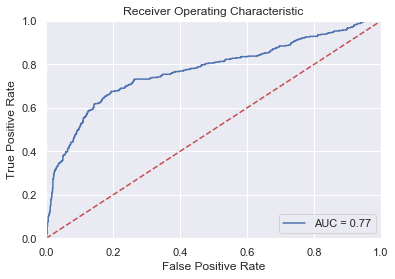

In [17]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Area Under the Curve (AUC)

In [21]:
print('AUC', round(metrics.roc_auc_score(y_test, pred_test_prob[:,1]),2))

AUC 0.77


#### Overall Accuracy

In [22]:
print('Overall Accuracy', round(metrics.accuracy_score(y_test, pred_test),2))

Overall Accuracy 0.78


In [23]:
confmat = metrics.confusion_matrix(y_test, pred_test)
confmat

array([[937,  65],
       [239, 168]], dtype=int64)

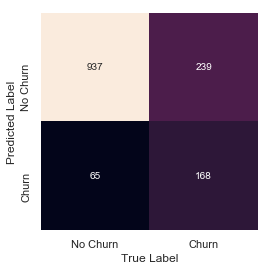

In [24]:
sns.heatmap(confmat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['No Churn','Churn'], yticklabels=['No Churn','Churn'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');

In [25]:
from sklearn.grid_search import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1, 10, 100]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [26]:
svc_param_selection(X_train, y_train, 10)

{'C': 100, 'gamma': 0.001}

In [27]:
svmc = svm.SVC(kernel='rbf', C=100, gamma=0.001, probability=True, random_state=2018)
svmc = svmc.fit(X_train, y_train)

### Predict on the Test data with fine tuned parameters

In [28]:
pred_test = svmc.predict(X_test)
pred_test_prob = svmc.predict_proba(X_test)

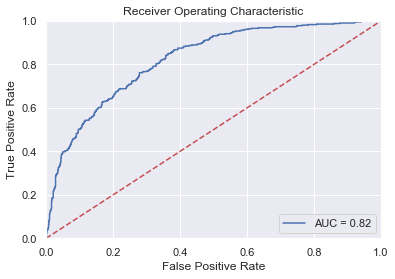

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
print('AUC', round(metrics.roc_auc_score(y_test, pred_test_prob[:,1]),2))
print('Overall Accuracy', round(metrics.accuracy_score(y_test, pred_test),2))

AUC 0.82
Overall Accuracy 0.78


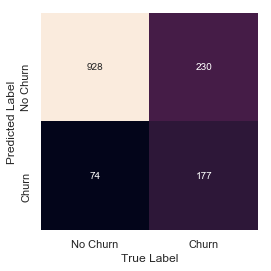

In [31]:
confmat = metrics.confusion_matrix(y_test, pred_test)
sns.heatmap(confmat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['No Churn','Churn'], yticklabels=['No Churn','Churn'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');